# Notebook Overview  
**Goal:** MB-pol simulation of a single Na⁺ ion (MB-nrg) solvated in 256 MB-pol water molecules.  
**Workflow:**  
1. Prepare all input files (`mbx.json`, `mbpol.param`, `start.lmp`, `sub.sh`).  
2. Run the production job on your HPC cluster.  
3. Post-process the trajectory with a lightweight *rerun* job.  
4. Visualize radial-distribution functions (RDFs) and mean-square displacements (MSDs).  

> **Data note:** An initial topology file named **`data.system`** containing *256 waters + 1 Na⁺* is already in this directory. 

**Challenge 1**: Go back to Tutorial 1 and modify the input files so it outputs exactly 256 waters and a single Na⁺ ion, then regenerate `data.system` with those settings.


### Preparing input files   
The next few cells create or copy each file into the working directory.


### Copy `mbx.json`  
Copies the `mbx.json` into the current folder so LAMMPS can locate MB-pol tables at runtime.  


In [2]:
!cp ../02_bulk_water_simulations/mbx.json .

### Create `mbpol.param`  
Creates the `mbpol.param` file, which isolates all MB-pol–specific pair styles and cut-offs.


In [3]:
mbpol_param_script = r"""
# MB-pol parameters for Na+/water system

# Defining the Force Field
pair_style      mbx  9.0       # distance cut-off 9.0
pair_coeff      * * 0.0 0.0   # providing dummy number for the pair_coeff
pair_modify     tail yes       # long range correction - yes

# Calculating MB-nrg decomposition
compute         mbx all pair mbx

# Command formula for `fix mbx` for a two-component system
fix             MBX all mbx 2 na+ 1 1 1 ${Na} h2o 2 3 3 ${O} ${H} ${H} json mbx.json
"""

with open('mbpol.param', 'w') as f:
    f.write(mbpol_param_script)

### Generate `start.lmp`  
Creates `start.lmp` with sensible defaults (0.5 fs timestep, 300 K, 1 atm, etc.).  
`read_data data.system` pulls in the pre-built topology that already contains 256 waters and one Na⁺ ion.


In [14]:
start_lmp_script = r"""
# MB-pol ion water simulation

# Define the required variables
variable        temp        equal  298.0
variable        dt          equal  0.5
variable        pressure    equal  1
variable        thermo_freq equal  500
variable        dump_freq   equal  500
variable        nsteps      equal  1000000
variable        print_freq  equal  500
variable        seed        equal  134678

timer           timeout 23:50:00 every 1000

# Basic setup
units           real
atom_style      full
boundary        p p p
processors      * * * map xyz

# Read initial configuration
read_data       data.system

# Define atom types and groups
variable        Na equal 1
variable        O  equal 2
variable        H  equal 3
group           na type 1
group           water type 2 3

# MB-pol parameter file
include         mbpol.param

# Neighbor list settings
neighbor        2.0 bin
neigh_modify    every 1 delay 10 check yes

# Timestep
timestep        ${dt}

# Thermodynamics output
thermo_style    custom step time temp etotal pe press vol density lx
thermo          ${thermo_freq}
thermo_modify   flush yes

# Set initial velocities
velocity        all create ${temp} ${seed} rot yes dist gaussian

# Print properties to files
fix             mbx_print all print ${print_freq} "$(time) $(c_mbx[1]) $(c_mbx[2]) $(c_mbx[3]) $(c_mbx[4]) $(c_mbx[6]) $(c_mbx[7]) $(c_mbx[8])" file mbx_thermo.out screen no title "# time e1b e2b e3b edisp ebuck eele etot"
fix             thermo_print all print ${print_freq} "$(step) $(time) $(temp) $(etotal) $(ke) $(pe) $(enthalpy) $(density) $(lx) $(ly) $(lz) $(vol) $(pxx) $(pyy) $(pzz) $(press)" file thermo.out screen no title "# step time temp etotal ke pe enthalpy density lx ly lz vol pxx pyy pzz press"

# NPT simulation integrator
fix             NPT all npt temp ${temp} ${temp} $(100.0*dt) iso ${pressure} ${pressure} $(1000.0*dt)

# Dump trajectory
dump            DUMP all custom ${dump_freq} traj_npt.lammpstrj id type xu yu zu
dump_modify     DUMP sort id

# Write restart files
restart         1000 restart.1 restart.2

# Run the simulation
run             ${nsteps}

# Write final configuration
write_data      final_data.system nocoeff
"""

with open('start.lmp', 'w') as f:
    f.write(start_lmp_script)

### Generate `sub.sh`  


In [15]:
sub_sh_script = r"""#!/bin/bash

#SBATCH --job-name="ion-water"
#SBATCH --partition=shared
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=32GB
#SBATCH -A csd973
#SBATCH --export=ALL
#SBATCH -t 24:00:00

module purge
module load shared slurm/expanse/23.02.7 sdsc/1.0 DefaultModules slurm/expanse/23.02.7 cpu/0.17.3b intel/19.1.3.304/6pv46so intel-tbb/2020.3/lfesfxm intel-mpi/2019.10.317/ezrfjne fftw/3.3.10/tqkvj37

lammps=/expanse/projects/qstore/csd973/bin/lmp_mpi_mbx

export OMP_NUM_THREADS=16

$lammps -in start.lmp
"""

with open('sub.sh', 'w') as f:
    f.write(sub_sh_script)

### How to Submit / Monitor  
Provides quick-start commands:  

* `!sbatch sub.sh` – queues the job.  
* `!squeue --me` – checks its status.  

In [16]:
!sbatch sub.sh

Submitted batch job 41041174


In [17]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          41041174    shared ion-wate   s7saha PD       0:00      1 (Priority)
          41018823    shared bulk-wat   s7saha  R   18:34:52      1 exp-1-03


### Generate `rerun_analysis.lmp`  
Writes a new LAMMPS script that:  

* `read_data data.system` – loads the original topology.  
* `rerun trajectory.lammpstrj` – feeds in frames from the production run.  
* Defines `compute rdf` and `compute msd` for water and Na⁺.  

Outputs plain-text files (`rdf.out`, `water_msd.out`, `na_msd.out`) for plotting.


In [ ]:
rerun_lmp_script = r"""
# MB-pol Ion-Water simulation (rerun for analysis)

# Setup
units           real
atom_style      full
boundary        p p p
read_data       data.system

# Definitions
variable        dt equal 0.5
variable        Na equal 1
variable        O  equal 2
variable        H  equal 3
group           na type 1
group           water type 2 3
timestep        ${dt}

# MB-pol parameter file
include mbpol.param

thermo          1
thermo_modify   flush yes

# RDF calculation for O-O and Na-O pairs
compute         myRDF all rdf 100 ${O} ${O} ${Na} ${O}
fix             rdfout all ave/time 1 1 100 c_myRDF[*] file rdf.out mode vector ave running

# MSD calculation for water
compute         WaterMSD water msd com yes average yes
fix             water_msd_print all print 1 "$(time) $(c_WaterMSD[4])" file water_msd.out screen no title "# time MSD_water"

# Rerun the trajectory
rerun           /expanse/projects/qstore/csd973/long_trajs/ionwater_traj/traj_npt.lammpstrj dump x y z
"""

with open('rerun_analysis.lmp', 'w') as f:
    f.write(rerun_lmp_script)

### Run Analysis Job  


In [2]:
sub_sh_script = r"""#!/bin/bash

#SBATCH --job-name="rerun"
#SBATCH --output="rerun.out"
#SBATCH --partition=debug
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=32GB
#SBATCH -A csd973
#SBATCH --export=ALL
#SBATCH -t 00:30:00

module purge
module load shared slurm/expanse/23.02.7 sdsc/1.0 DefaultModules slurm/expanse/23.02.7 cpu/0.17.3b intel/19.1.3.304/6pv46so intel-tbb/2020.3/lfesfxm intel-mpi/2019.10.317/ezrfjne fftw/3.3.10/tqkvj37

lammps=/expanse/projects/qstore/csd973/bin/lmp_mpi_mbx

export OMP_NUM_THREADS=16

$lammps -in rerun_analysis.lmp -log rerun.log
"""

with open('resub.sh', 'w') as f:
    f.write(sub_sh_script)

In [3]:
!sbatch resub.sh

Submitted batch job 41045765


In [4]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          41045765     debug    rerun   s7saha  R       0:01      1 exp-9-55
          41045762     debug    rerun   s7saha  R       0:22      1 exp-9-55
          41041174    shared ion-wate   s7saha  R    5:42:14      1 exp-1-27


In [7]:
!tail rerun.out

[MBX] ELE_PME_D           :        8.5733        8.5733        8.5733      5409    15.48%
[MBX] ELE_PME_E           :       0.91441       0.91441       0.91441       427     1.65%
[MBX] DISP_PME_SETUP      :       0.88175       0.88175       0.88175       427     1.59%
[MBX] DISP_PME_E          :        1.4096        1.4096        1.4096       427     2.55%
[MBX] ELE_COMM_REVFOR     :      0.090833      0.090833      0.090833      5409     0.16%
[MBX] ELE_COMM_REVSET     :     0.0084485     0.0084485     0.0084485       427     0.02%
[MBX] ELE_COMM_REV        :    0.00099295    0.00099295    0.00099295      4982     0.00%
[MBX] ELE_COMM_FORSET     :      0.036591      0.036591      0.036591       427     0.07%
[MBX] ELE_COMM_FOR        :      0.028009      0.028009      0.028009      4982     0.05%
Total wall time: 0:00:55


### Plot RDFs + MSDs

Python code reads the output files, constructs distance/time arrays, and uses `matplotlib` to draw:

- **g<sub>NaO</sub>(r)** — Na⁺–oxygen radial-distribution function  
- **g<sub>OO</sub>(r)** — water oxygen–oxygen RDF  
- **MSD(t)** — separate curves for water


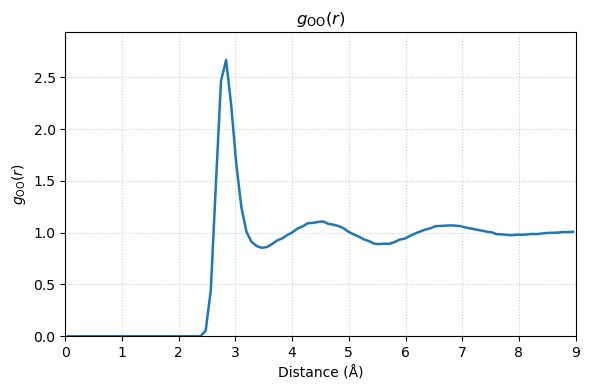

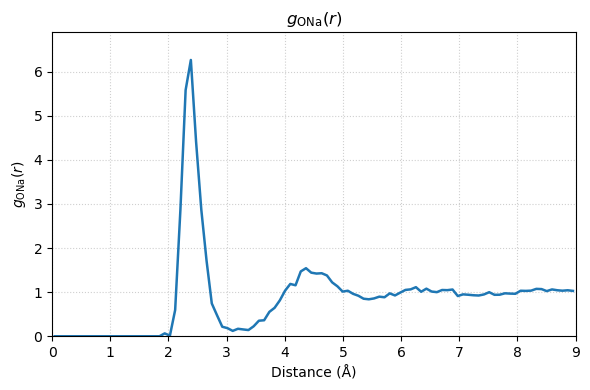

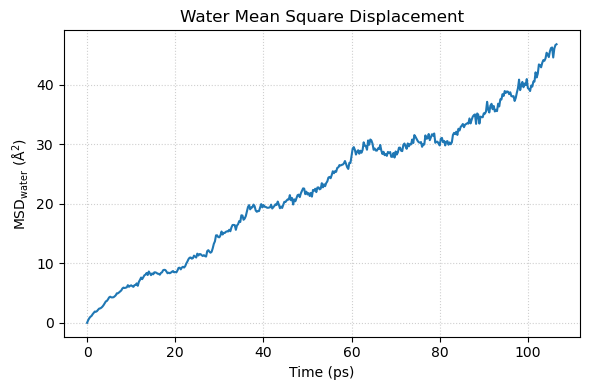

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- File names ---
rdf_file       = "rdf.out"
water_msd_file = "water_msd.out"
# --------------------

# --- Read RDF file and find last block header ---
with open(rdf_file, "r") as fh:
    lines = fh.readlines()

blocks = []
for i, ln in enumerate(lines):
    if ln.startswith("#"):
        continue
    toks = ln.split()
    if len(toks) == 2 and toks[0].isdigit() and toks[1].isdigit():
        ts, nbins = map(int, toks)
        blocks.append((i+1, nbins, ts))

# pick the last block
start, nbins, last_ts = blocks[-1]

# load exactly nbins data rows
rdf_block = [
    [float(x) for x in ln.split()]
    for ln in lines[start : start + nbins]
    if ln.strip() and not ln.startswith("#")
]
data = np.array(rdf_block)

# extract columns: 
#   column 1 = r, 
#   column 2 = c_myRDF[2] = g_OO, 
#   column 4 = c_myRDF[3] = g_ONa
r_vals = data[:, 1]
g_OO   = data[:, 2]
g_ONa  = data[:, 4]

# --- Plot g_OO(r) ---
plt.figure(figsize=(6,4))
plt.plot(r_vals, g_OO, lw=1.8)
plt.xlabel("Distance (Å)")
plt.ylabel(r"$g_{\mathrm{OO}}(r)$")
plt.title(f"$g_{{\mathrm{{OO}}}}(r)$")
plt.xlim(0, 9)
plt.ylim(0, g_OO.max() * 1.1)
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

# --- Plot g_ONa(r) ---
plt.figure(figsize=(6,4))
plt.plot(r_vals, g_ONa, lw=1.8)
plt.xlabel("Distance (Å)")
plt.ylabel(r"$g_{\mathrm{ONa}}(r)$")
plt.title(f"$g_{{\mathrm{{ONa}}}}(r)$")
plt.xlim(0, 9)
plt.ylim(0, g_ONa.max() * 1.1)
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

# --- Load MSD data ---
df_water = pd.read_csv(
    water_msd_file,
    sep=r'\s+',
    comment="#",
    header=None,
    names=["time_fs", "msd_water"]
)

# convert to ps and arrays
t_w = df_water["time_fs"].to_numpy() / 1e3  # fs → ps
m_w = df_water["msd_water"].to_numpy()

# --- Plot Water MSD ---
plt.figure(figsize=(6,4))
plt.plot(t_w, m_w, lw=1.5)
plt.xlabel("Time (ps)")
plt.ylabel(r"MSD$_\mathrm{water}$ (Å$^{2}$)")
plt.title("Water Mean Square Displacement")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

# --- Show all figures ---
plt.show()
